In [2]:
import networkx as nx
import random
import math
import copy
from matplotlib import pyplot as plt

In [3]:
def euclid_distance(u_x: float,
                    u_y: float,
                    v_x: float,
                    v_y: float) -> float:
    return math.sqrt((u_x - v_x)**2 + (u_y - v_y)**2)

In [4]:
def read_instance(file_path: str) -> nx.Graph:
    with open(file_path, 'r') as f:
        g = nx.Graph()
        for line in f:
            if line[0].isdigit():
                node_id, x, y = [float(a) for a in line.split()]
                g.add_node(int(node_id) - 1, x=x, y=y)
        
        for u in range(len(g.nodes)):
            for v in range(u + 1, len(g.nodes)):
                
                weight = euclid_distance(g.nodes[u]['x'],
                                        g.nodes[u]['y'],
                                        g.nodes[v]['x'],
                                        g.nodes[v]['y'])
                
                g.add_edge(u, v, weight=weight, pheromones=1)
                
        return g

In [5]:
g0 = read_instance(file_path='dj38.tsp')

In [6]:
g1 = read_instance(file_path='att48.tsp')

In [7]:
class Harmony: 
    def __init__(self, g : nx.Graph, cycleList : list, alpha: float, beta: float):
        if alpha != None:
            self.cycle, self.fitness = self.hamiltonian(g, alpha, beta)
        if cycleList == None:
            self.cycle, self.fitness = self.hamiltonian(g, None, None)
        else:
            self.cycle, self.fitness = self.calcFitness(cycleList, g)
    
    def __str__(self):
        return ' '.join([str(u) for u in self.cycle]) + f' {self.fitness}'
    
    def __getitem__(self,index):
        return self.cycle[index]
    
    start=0
    
    def hamiltonian(self, g: nx.Graph, alpha: float, beta: float):
        start = self.start
        cycle = [start]
        cycle_weight = 0
        visited = {start}
        u = start
        while len(visited) != len(g.nodes):
            neighbours = [v for v in g[u] if v not in visited]
            
            if alpha != None:
                values = [g[u][v]['pheromones']**alpha / g[u][v]['weight']**beta for v in neighbours]
            else:
                values = None
                
            chosen_neighbour = random.choices(neighbours, weights=values, k=1)[0]
            cycle.append(chosen_neighbour)
            visited.add(chosen_neighbour)
            cycle_weight += g[u][chosen_neighbour]['weight']
            u = chosen_neighbour
        
        cycle_weight += g[start][cycle[-1]]['weight']
        return cycle, cycle_weight
    
    def calcFitness(self, cycleList : list, g : nx.Graph):
        fitness = g[cycleList[0]][cycleList[-1]]['weight']
        for u, v in zip(cycleList[:-1], cycleList[1:]):
            fitness += g[u][v]['weight']
        return cycleList, fitness

In [18]:
def HarmonySearch(
    g: nx.Graph,
    HMS: int, #number of harmonies
    HMCR: float, #harmony memory accepting rate
    PAR: float, #pitch adjusting rate
    mpr: float, #mutation probability rate
    er: int, #elite rate
    rho: float,
    alpha: float,
    beta: float,
    theta: float,
    maxIterations: int
):
    HarmonyMemory = [Harmony(g, None, None, None) for _ in range(HMS)]
    HarmonyMemory.sort(key= lambda x : x.fitness, reverse=False)
    
    pheromoneUpdate(g, HarmonyMemory, theta)
    
    c = 0
    gc = 0
    bestOfHM = []
    
    for t in range(maxIterations):
        numOfCities = len(g.nodes())
        
        for u in range(numOfCities):
            for v in range(u + 1, numOfCities):
                g[u][v]['pheromones'] *= rho
        
        harmonyCycle = []
        for i in range(numOfCities):
             
            if random.random() < HMCR:
                #chose a value from HM for the variable i (play same harmony)
                harmonyCycle = chooseFromHM(HarmonyMemory, harmonyCycle, i)
                if random.random() < PAR:
                    #adjust the value (improvise on harmony)
                    harmonyCycle = adjustHarmony(harmonyCycle, g)
            else:
                #chose random harmony (improvise)
                harmonyCycle = improvise(harmonyCycle, g)
            
            if len(harmonyCycle) != i+1 : #node doesnt have unvisited neighbor
                break
            
        #accept solution if better than worst
        #(calc fitness and sort hm fitnesses)
        if len(g.nodes) != len(harmonyCycle):
            c+=1
            continue
        
        newHarmony = Harmony(g, harmonyCycle, None, None)
        
        if(newHarmony.fitness < HarmonyMemory[HMS-1].fitness):
            
            HarmonyMemory.remove(HarmonyMemory[HMS-1])
            HarmonyMemory.append(newHarmony)
            HarmonyMemory.sort(key= lambda x : x.fitness, reverse=False)
            gc += 1
        bestOfHM.append(sum([f.fitness for f in HarmonyMemory[0:3]])/3)
        
            #mutation
        if random.random() < mpr:
            for h in HarmonyMemory[int(er*HMS):]:
                mCycle = mutation(h.cycle)
                mutant = Harmony(g, mCycle, None,None)
                
                HarmonyMemory.remove(h)
                HarmonyMemory.append(mutant)
            
            HarmonyMemory.sort(key= lambda x : x.fitness, reverse=False)
        
        #update pheromones
        
        pheromoneUpdate(g, HarmonyMemory, theta)
        
        for i in range(HMS):
            HarmonyMemory.append(Harmony(g, None, alpha, beta))
        
        HarmonyMemory.sort(key= lambda x : x.fitness, reverse=False)
        HarmonyMemory = copy.deepcopy(HarmonyMemory[:HMS])
        
        #pheromoneUpdate(g, HarmonyMemory, theta)
        
    print('Cycles founded: ', maxIterations-c)
    print('Good cycles founded: ', gc)
        
    plt.plot(range(len(bestOfHM)), bestOfHM)
        
    #return best solution
             
    h = HarmonyMemory[0]
    return h

In [9]:
def chooseFromHM(HarmonyMemory : list, harmony : list, i : int) -> list:
    candidates = []
    weights = []
    maxF = 0
    
    for h in HarmonyMemory:
        if h[i] not in harmony:
            candidates.append(h[i])
            weights.append(h.fitness)
            if h.fitness > maxF:
                maxF = h.fitness
    if len(candidates) == 0:
        return harmony
    
    weights[:] = [w/maxF for w in weights]
    harmony.append(random.choices(candidates, weights=weights, k=1)[0])
    return harmony

In [10]:
def adjustHarmony(harmony : list, g : nx.Graph) -> list:
    
    neighbors = [u for u in g.neighbors(harmony[-1])]
    
    #random.shuffle(neighbors)
    neighbors.sort(key = lambda x: g[harmony[-1]][x]['weight'])
    
    for u in neighbors:
        if u not in harmony:
            harmony.remove(harmony[-1])
            harmony.append(u)
            return harmony
    return harmony

In [11]:
def improvise(harmony: list, g: nx.Graph) -> list:
    
    candidates = [c for c in g.nodes()]
    
    random.shuffle(candidates)
    
    for c in candidates:
        if c not in harmony:
            harmony.append(c)
            return harmony
    return harmony

In [12]:
def mutation(harmony: list) -> list:
    selected = random.choices(range(0,len(harmony)),weights=None, k=random.randint(2, int(len(harmony)/2)))
    
    t = 0
    while t < len(selected)/2:
        tmp = harmony[selected[t]]
        harmony[selected[t]] = harmony[selected[-t-1]]
        harmony[selected[-t-1]] = tmp
        t+=1
        
    return harmony

In [13]:
def pheromoneUpdate(g: nx.Graph, HarmonyMemory: list, theta):
    for h in HarmonyMemory:
            delta = theta / h.fitness
            for u, v in zip(h.cycle[:-1], h.cycle[1:]):
                g[u][v]['pheromones'] += delta
            g[h.cycle[0]][h.cycle[-1]]['pheromones'] += delta

Cycles founded:  778
Good cycles founded:  778
0 4 6 14 20 13 34 1 22 24 37 36 33 27 31 25 12 7 11 15 30 35 29 28 9 26 5 21 16 8 17 10 32 23 2 3 18 19 20196.549479770478


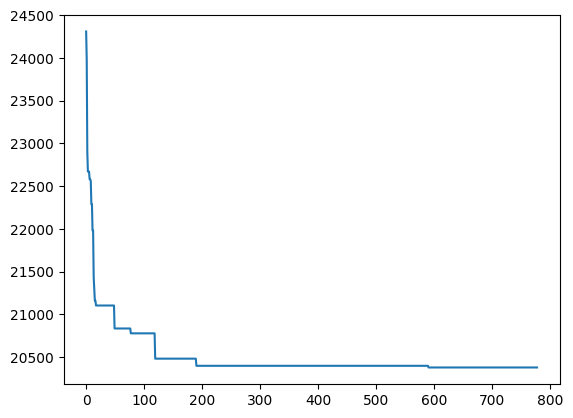

In [17]:
HMS = 100
HMCR = 0.95
PAR = 0.55

mpr = 0.01
ER = 0.2

rho = 0.05
alpha = 0.9
beta = 1.5
theta = 100.0

maxIterations = 1000
print(HarmonySearch(g0, HMS, HMCR, PAR, mpr, ER, rho, alpha, beta, theta, maxIterations))